Reference: https://medium.com/@murtuza753/using-llama-2-0-faiss-and-langchain-for-question-answering-on-your-own-data-682241488476

Langchain Modules:

- Prompts: This module allows you to build dynamic prompts using templates. It can adapt to different LLM types depending on the context window size and input variables used as context, such as conversation history, search results, previous answers, and more.
- Models: This module provides an abstraction layer to connect to most available third- party LLM APIs. It has API connections to ~40 public LLMs, chat and embedding models.
- Memory: This gives the LLMs access to the conversation history.
- Indexes: Indexes refer to ways to structure documents so that LLMs can best interact with them. This module contains utility functions for working with documents and integration to different vector databases.
- Agents: Some applications require not just a predetermined chain of calls to LLMs or other tools, but potentially to an unknown chain that depends on the user’s input. In these types of chains, there is an agent with access to a suite of tools. Depending on the user’s input, the agent can decide which — if any — tool to call.
- Chains: Using an LLM in isolation is fine for some simple applications, but many more complex ones require the chaining of LLMs, either with each other, or other experts. LangChain provides a standard interface for Chains, as well as some common implementations of chains for ease of use.

- FAISS: is a library for efficient similarity search and clustering of dense vectors. It can search multimedia documents (e.g. images) in ways that are inefficient or impossible with standard database engines (SQL). It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning.



- Process flow
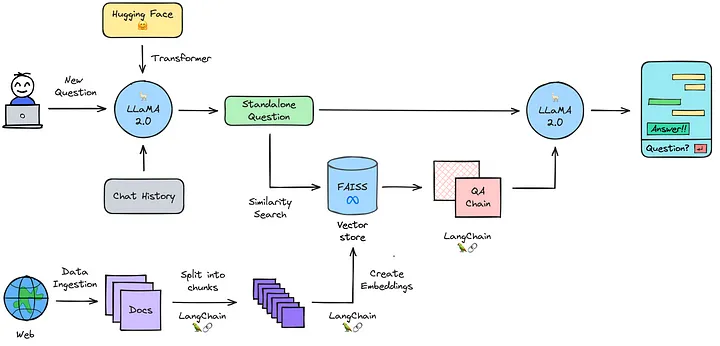

Resources needed:

Hugging Face token: go to your Hugging Face Profile > Settings > Access Token > New Token > Generate a Token

Now, I just put Author's code here:

In [1]:
from torch import cuda, bfloat16
import transformers

model_id = 'meta-llama/Llama-2-7b-chat-hf'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

# begin initializing HF items, you need an access token
hf_auth = '<add your access token here>'
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=hf_auth
)

# enable evaluation mode to allow model inference
model.eval()

print(f"Model loaded on {device}")

/home/researcher/.pyenv/versions/3.11.7/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PackageNotFoundError: No package metadata was found for bitsandbytes

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

In [ ]:
stop_list = ['\nHuman:', '\n```\n']

stop_token_ids = [tokenizer(x)['input_ids'] for x in stop_list]
stop_token_ids

In [ ]:
import torch

stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]
stop_token_ids

In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

# define custom stopping criteria object
class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_ids in stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():
                return True
        return False

stopping_criteria = StoppingCriteriaList([StopOnTokens()])

In [ ]:
generate_text = transformers.pipeline(
    model=model, 
    tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation',
    # we pass model parameters here too
    stopping_criteria=stopping_criteria,  # without this model rambles during chat
    temperature=0.1,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=512,  # max number of tokens to generate in the output
    repetition_penalty=1.1  # without this output begins repeating
)

In [ ]:
res = generate_text("Explain me the difference between Data Lakehouse and Data Warehouse.")
print(res[0]["generated_text"])